# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file.

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts depending on how you perform in the following sections.

To get started, you must make a copy of this template and rename it under this format: **yourUVaID_assignment_1.ipynb**. You will need to submit it with all of your outputs included to Gradecope.


***
##  Task 1: SEE THE BIG PICTURE
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

We are addressing a regression problem to predict medical costs of individuals based on certain characteristics from the Kaggle dataset. The goal is to build a model that can accurately estimate one's personal medical costs based on their known attributes such as age and sex, as well as habits such as smoking that could impact this value.

In [150]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(74)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
def loadMedicalCostData():
  return pd.read_csv('insurance.csv')

data = loadMedicalCostData()
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [151]:
size_in_mb = data.memory_usage(deep=True).sum() / (pow(2,20))
num_entries = len(data)
num_features = data.shape[1]
categorical_data = data.select_dtypes(include=['object']).columns.tolist()
missing_values = data.isnull().sum()
basic_stats = data.describe()

print(f'1. Size in MB: {size_in_mb}\n')
print(f'2. Number of entries: {num_entries}\n')
print(f'3. Number of features: {num_features}\n')
print(f'4. Categorical data columns:\n {categorical_data}\n')
print(f'5. Missing values:\n {missing_values}\n')
print(f'6. Basic Stats:\n {basic_stats}')

1. Size in MB: 0.2798175811767578

2. Number of entries: 1338

3. Number of features: 7

4. Categorical data columns:
 ['sex', 'smoker', 'region']

5. Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

6. Basic Stats:
                age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING

**Data Discover:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class.

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

In [152]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# Your code goes here for this section.
X_train = [];
y_train = [];
X_test = [];
y_test = [];

# Stratified based on smoking data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=74)
for train_index, test_index in split.split(data, data["smoker"]):
    train_data = data.loc[train_index]
    test_data = data.loc[test_index]

X_train = train_data.drop('charges', axis=1)
y_train = train_data["charges"].copy()
X_test = test_data.drop('charges', axis=1)
y_test = test_data["charges"].copy()

numerical_features = ["age", "bmi", "children"]
categorical_features = ['sex', 'smoker', 'region']

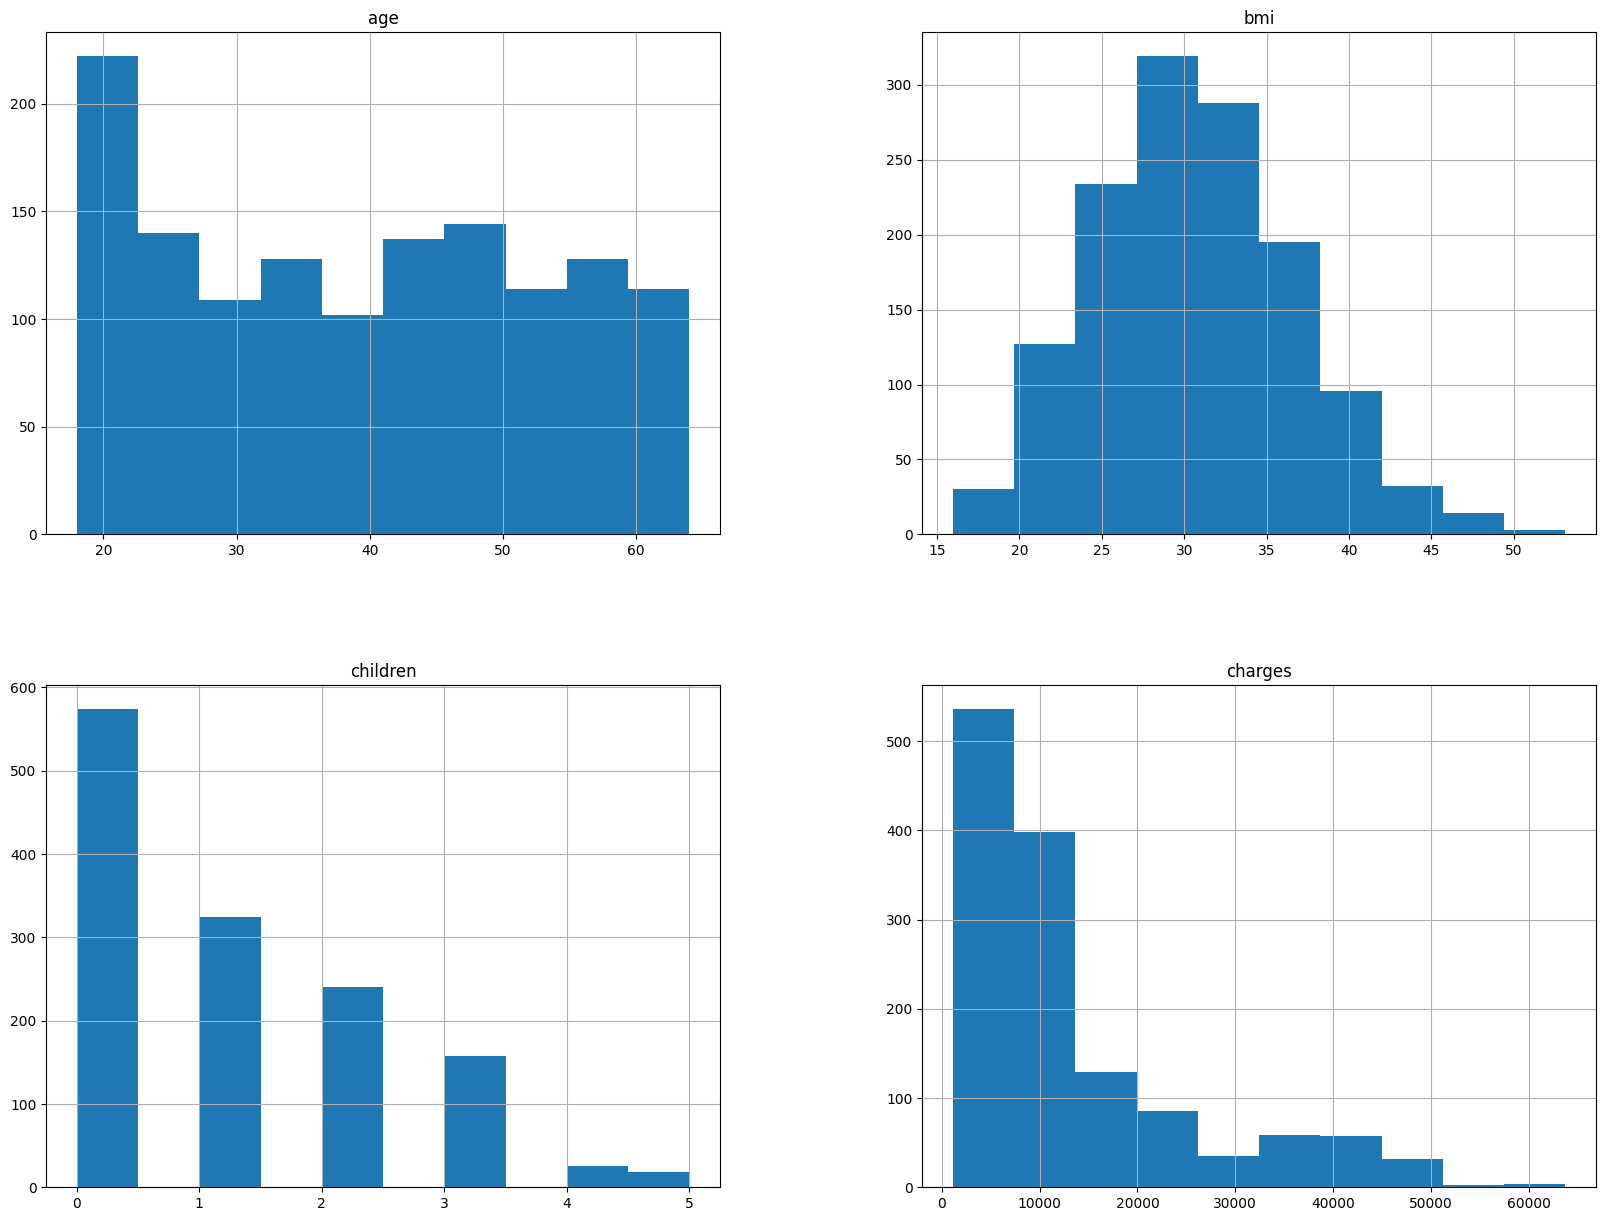

sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


In [153]:
%matplotlib inline
import matplotlib.pyplot as plt
# All numerical cols
data.hist(figsize=(20,15))
plt.show()
# Categorical data
for category in categorical_features:
  print(data[category].value_counts())

In [154]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["charges"].sort_values(ascending=False)

,charges
charges,1.000000
age,0.299008
bmi,0.198341
children,0.067998


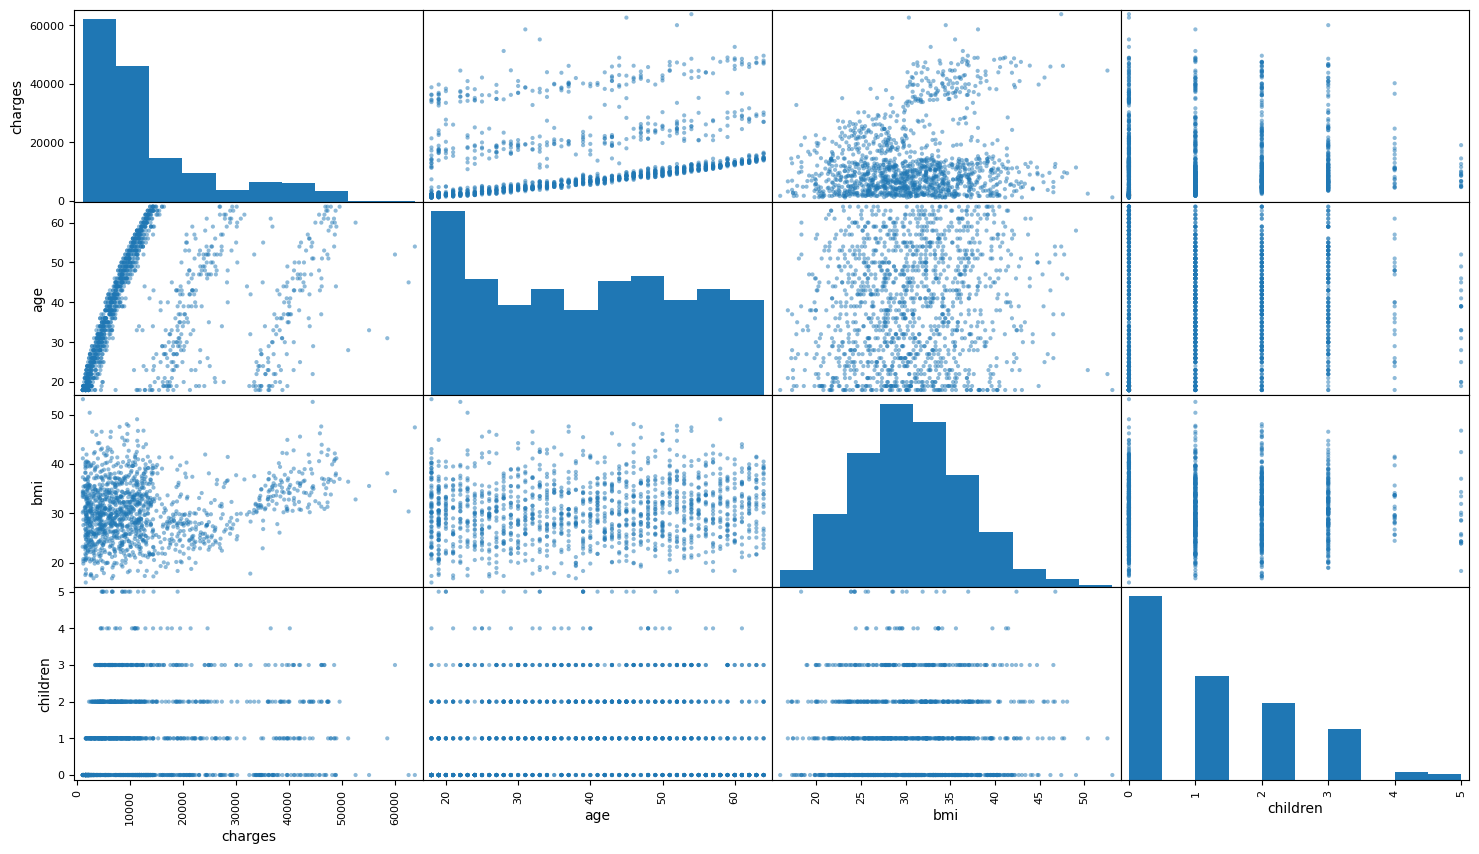

In [155]:
from pandas.plotting import scatter_matrix

all_numerical_features = ["charges", "age", "bmi", "children"]
scatter_matrix(data[all_numerical_features], figsize=(18, 10))
plt.show()

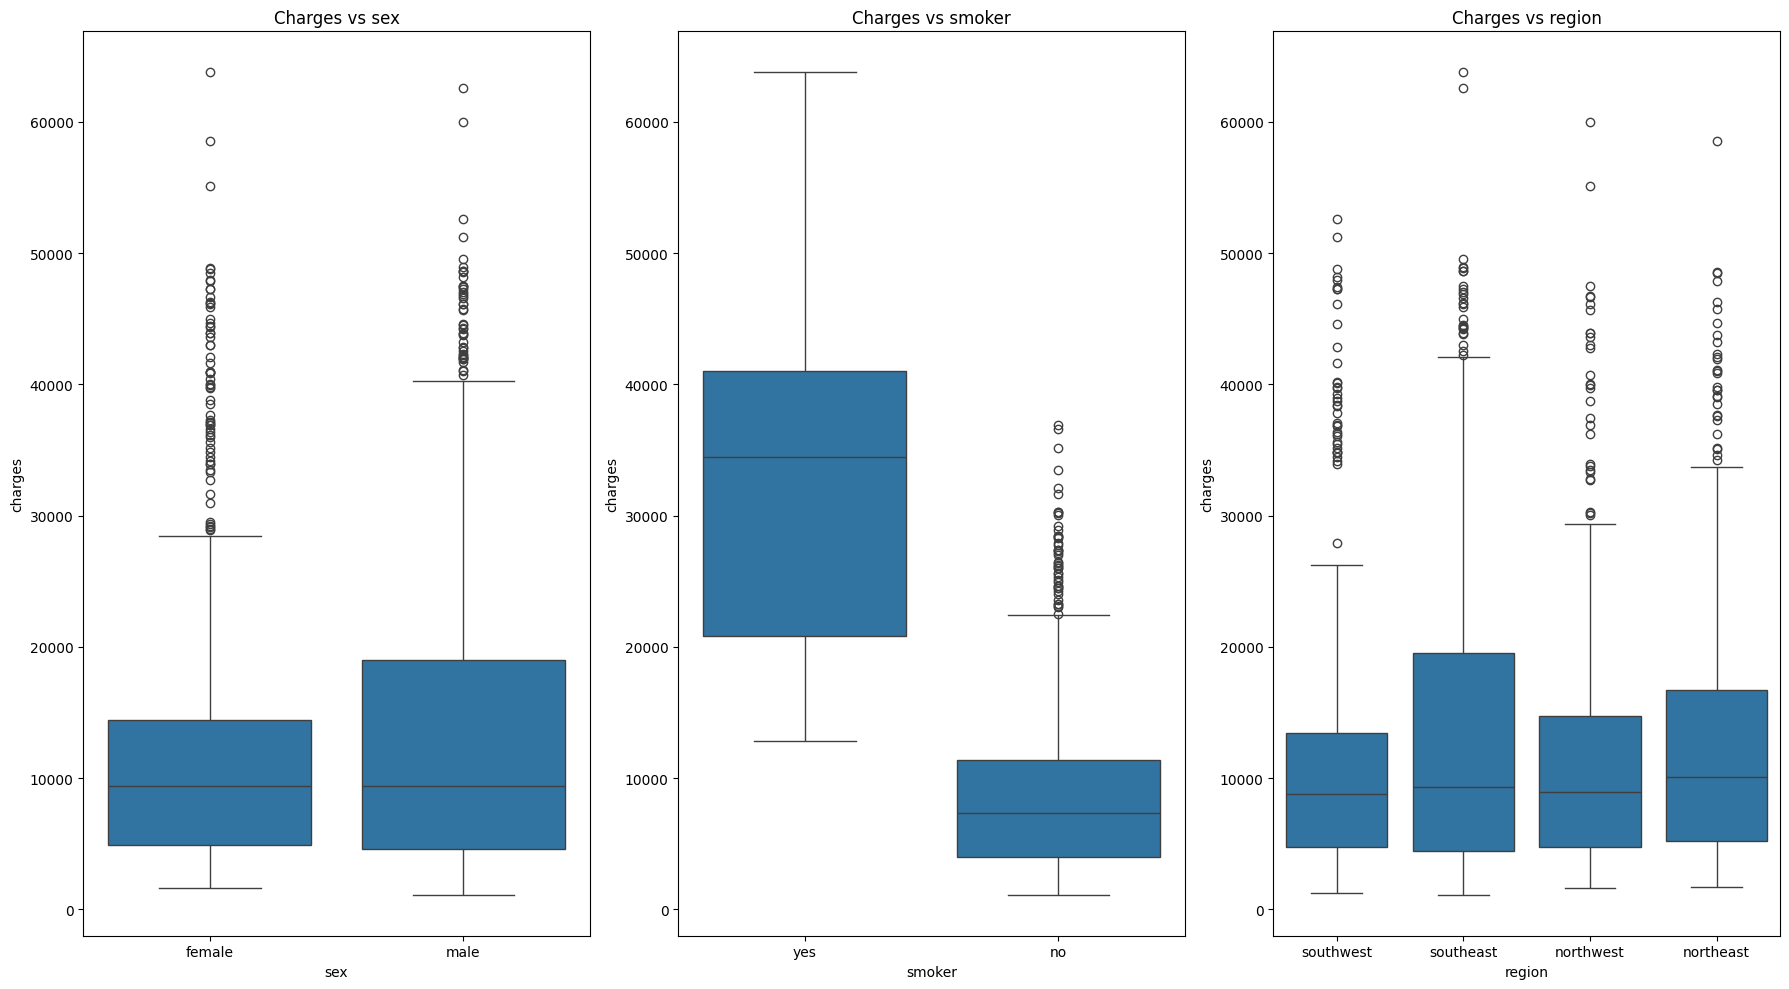

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

for i, category in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)  # Creating a subplot for each categorical feature
    sns.boxplot(x=category, y='charges', data=data)
    plt.title(f'Charges vs {category}')
    plt.tight_layout()

plt.show()

In [157]:
from sklearn.compose import ColumnTransformer

# Numerical
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
])

# Full
full_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline,categorical_features)
    ]
)

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods.

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [158]:
class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = None  # parameter vector
    self.alpha = 0.33   # learning rate
    self.cost  = None  # cost function
    self.iters = 250   # number of iterations

  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    # y_train = y_train.reshape(-1, 1)

    X_b = np.c_[np.ones((len(X_train), 1)), X_train]
    y_train = y_train[:,np.newaxis]
    self.theta = np.random.randn(len(X_b[0]),1)
    self.theta, self.cost = self.gradientDescent(X_b, y_train, self.theta, self.alpha, self.iters)
    return self.cost

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    # y_train = y_train.reshape(-1, 1)

    m = len(X_train)
    X_b = np.c_[np.ones((len(X_train), 1)), X_train]
    y_train = y_train[:,np.newaxis]
    self.theta = np.linalg.pinv(X_b).dot(y_train)
    self.cost = (1/m*(X_b.dot(self.theta)-y_train)**2).sum()
    return self.cost

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT:
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    m = X_train.shape[0]
    for iteration in range (0, iters):
      gradients = 2/m*X_train.T.dot(X_train.dot(theta)-y_train)
      theta = theta - alpha*gradients

    self.theta = theta
    self.cost = (1/m*(X_train.dot(self.theta)-y_train)**2).sum()
    return self.theta, self.cost


  def predict(self, X_test):
    """
    Predicting the label
    """
    X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]
    y_predict = X_test_b.dot(self.theta)
    return y_predict

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    # implement here to return("Parameter vector is %f" % self.theta)   }

# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()

myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)

36633384.01757517

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

In [159]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.
#
# plt.set_xlabel('Iterations')
# plt.set_ylabel('Cost')
# plt.set_title('Error vs. Training Iterations')

# Custom function to plot curves of different magnitude
def plotLearningRate(iters, alphas, figsize=(20, 15)):

  plt.figure(figsize=figsize)
  legend=[]

  for a in alphas:
    myGradientDescentModel.alpha = a/10000
    costs = []
    for i in iters:
      myGradientDescentModel.iters = i
      costs.append(myGradientDescentModel.fitUsingGradientDescent(X_train, y_train))

    plt.plot(iters,costs)
    plt.annotate(f'α={myGradientDescentModel.alpha:.3f}',
                  xy=(iters[0], costs[0]), xycoords='data',
                  xytext=(-40, 0), textcoords='offset points',
                  fontsize=10, color='black') # to see lines clearly (am colorblind)
    legend.append("alpha="+str(myGradientDescentModel.alpha))

  plt.legend(legend)
  plt.xlabel('Iterations')
  plt.ylabel('Cost')
  plt.title('Error vs. Training Iterations')

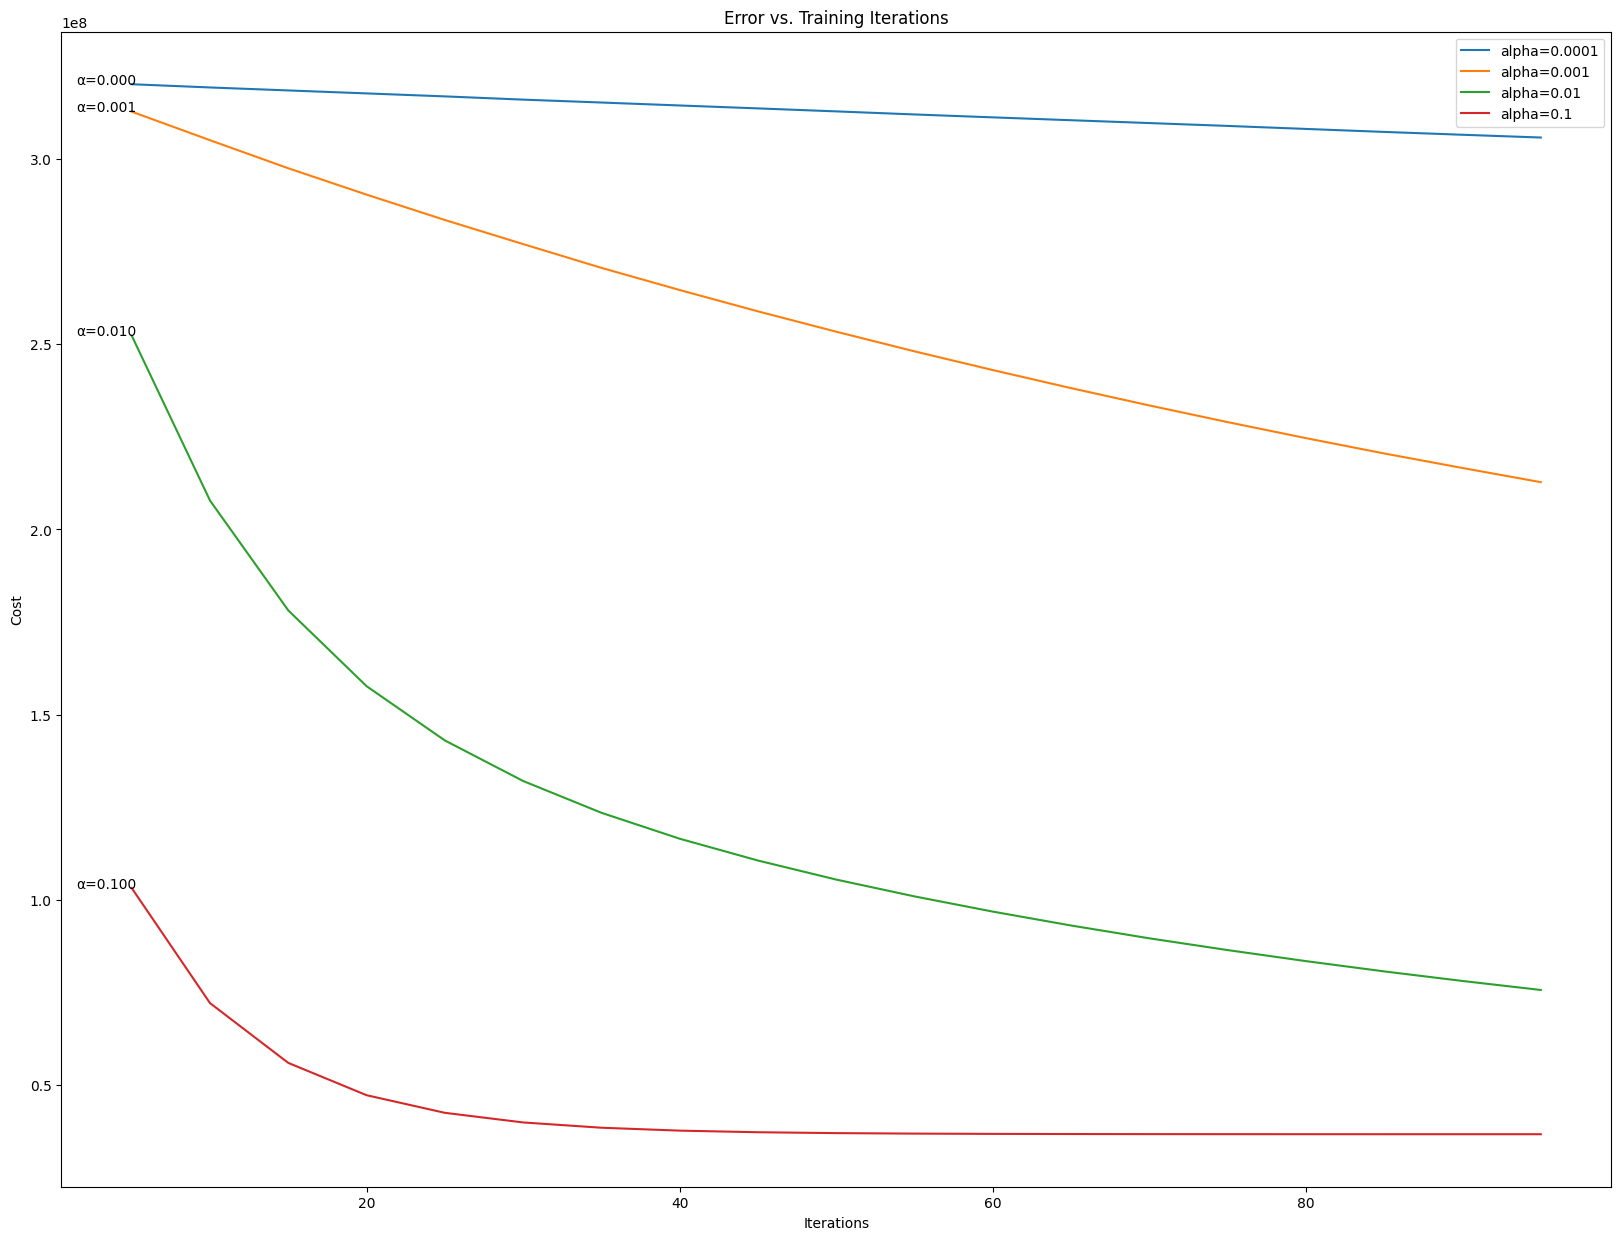

In [160]:
# See which order of magnitude is in the correct ballpark
plotLearningRate(list(range(5,100,5)), [1, 10, 100, 1000]) # 1/10000 to 1/10
# Note that 10000 (1/1) blows up

By the graph, we can see the the learning rate converges quickest on the order of magnitude of 0.1. We now focus on this order of magnitude and see which value around this is the best.

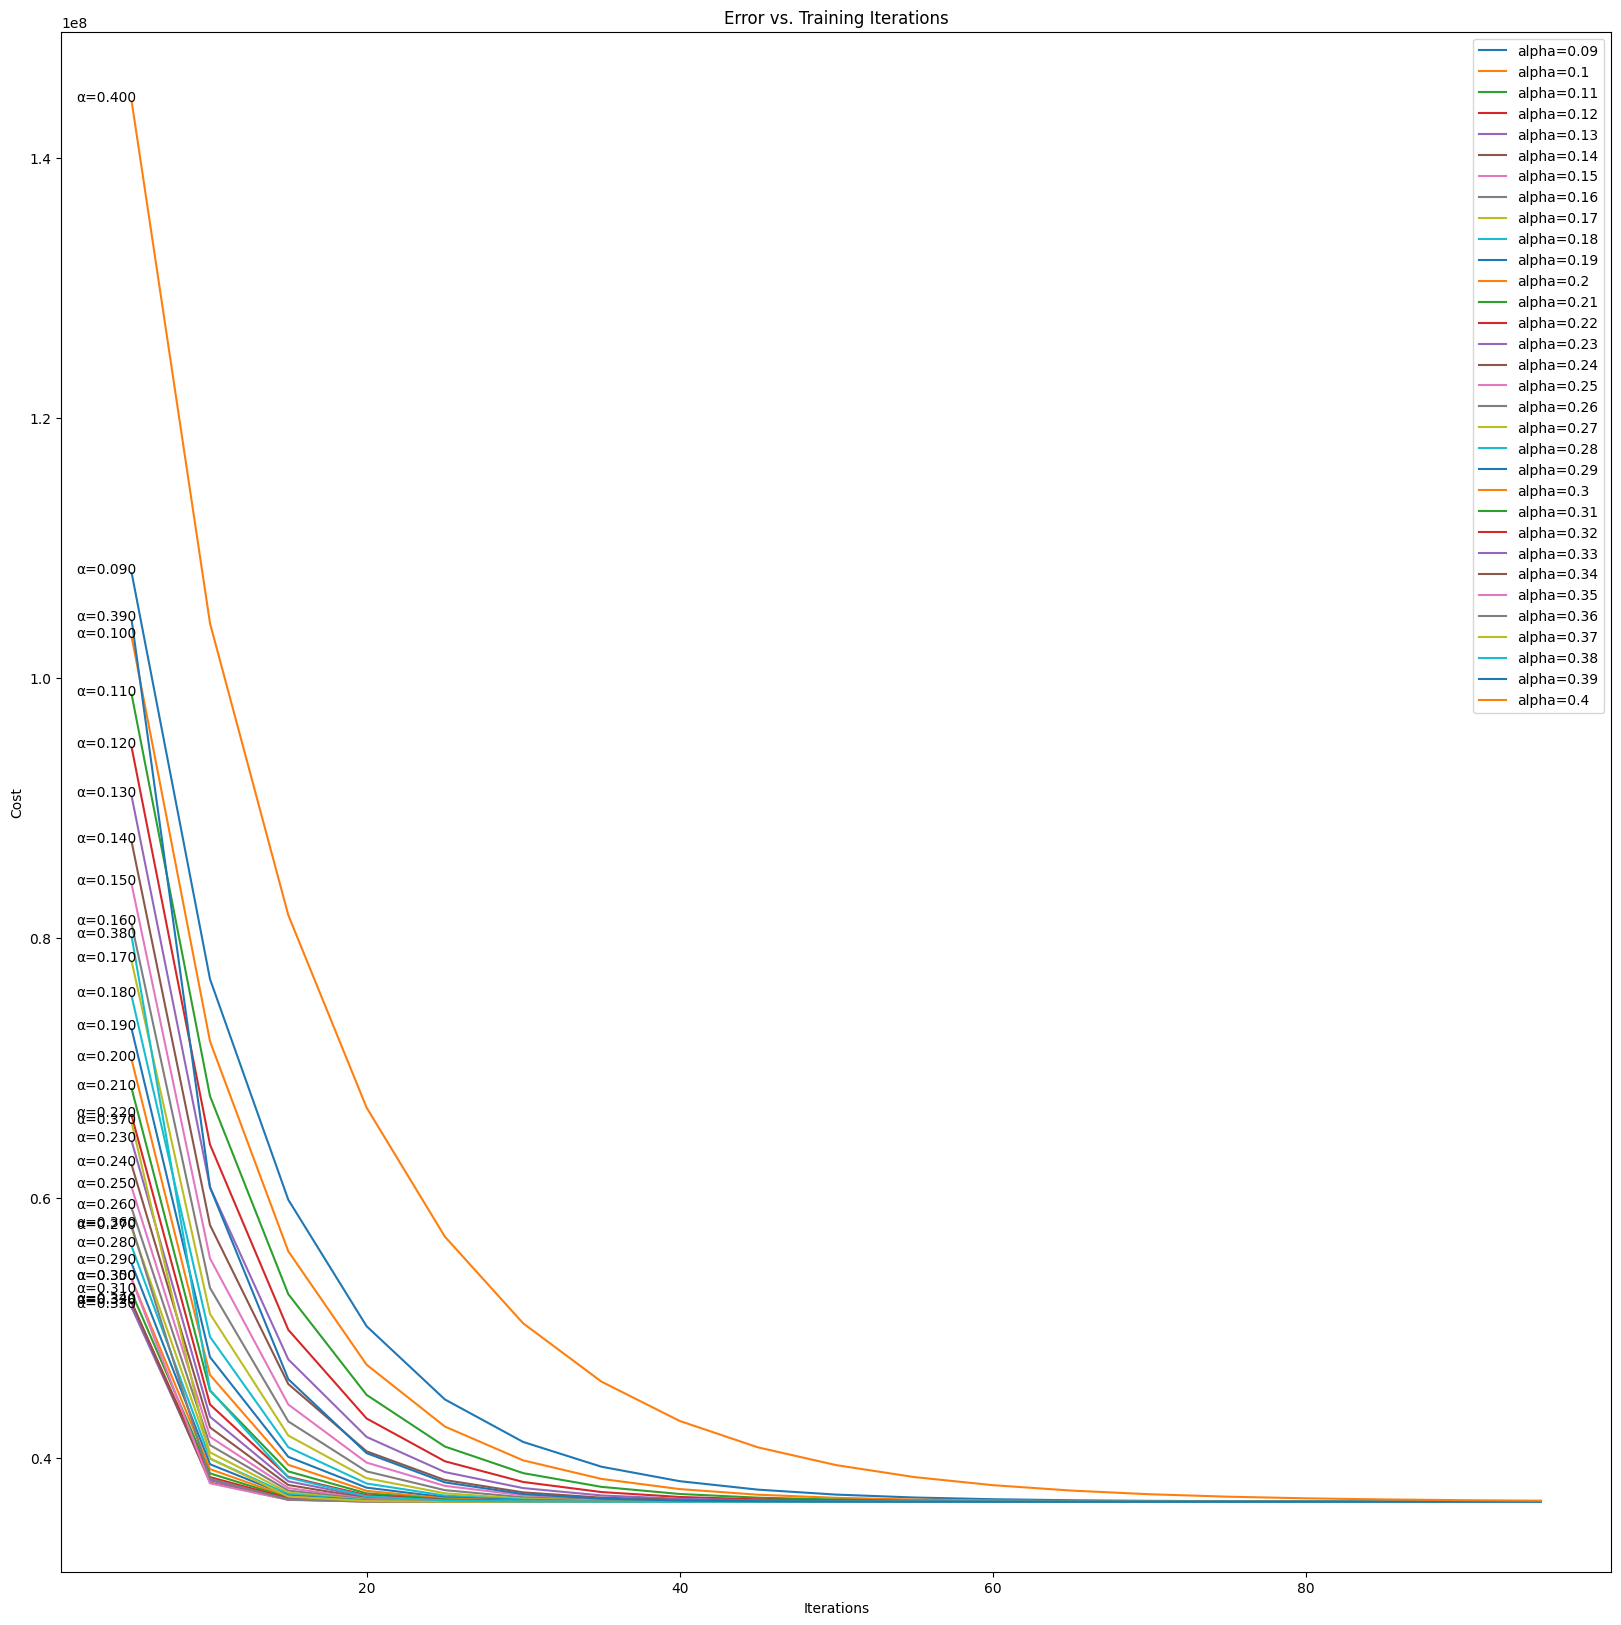

In [161]:
# Now, focus on values around 0.100
plotLearningRate(list(range(5,100,5)), list(range(900, 4100, 100)), figsize = (20,20))

Notice that the error in general converges more quickly as the learning rate incraeses, until about 0.33 and above where goes the wrong way until 0.40 where it's much worse than 0.09. Upon further testing, as soon as I get to 0.41, the graph completely diverges. Now, I focus on even smaller increments in a smaller range.


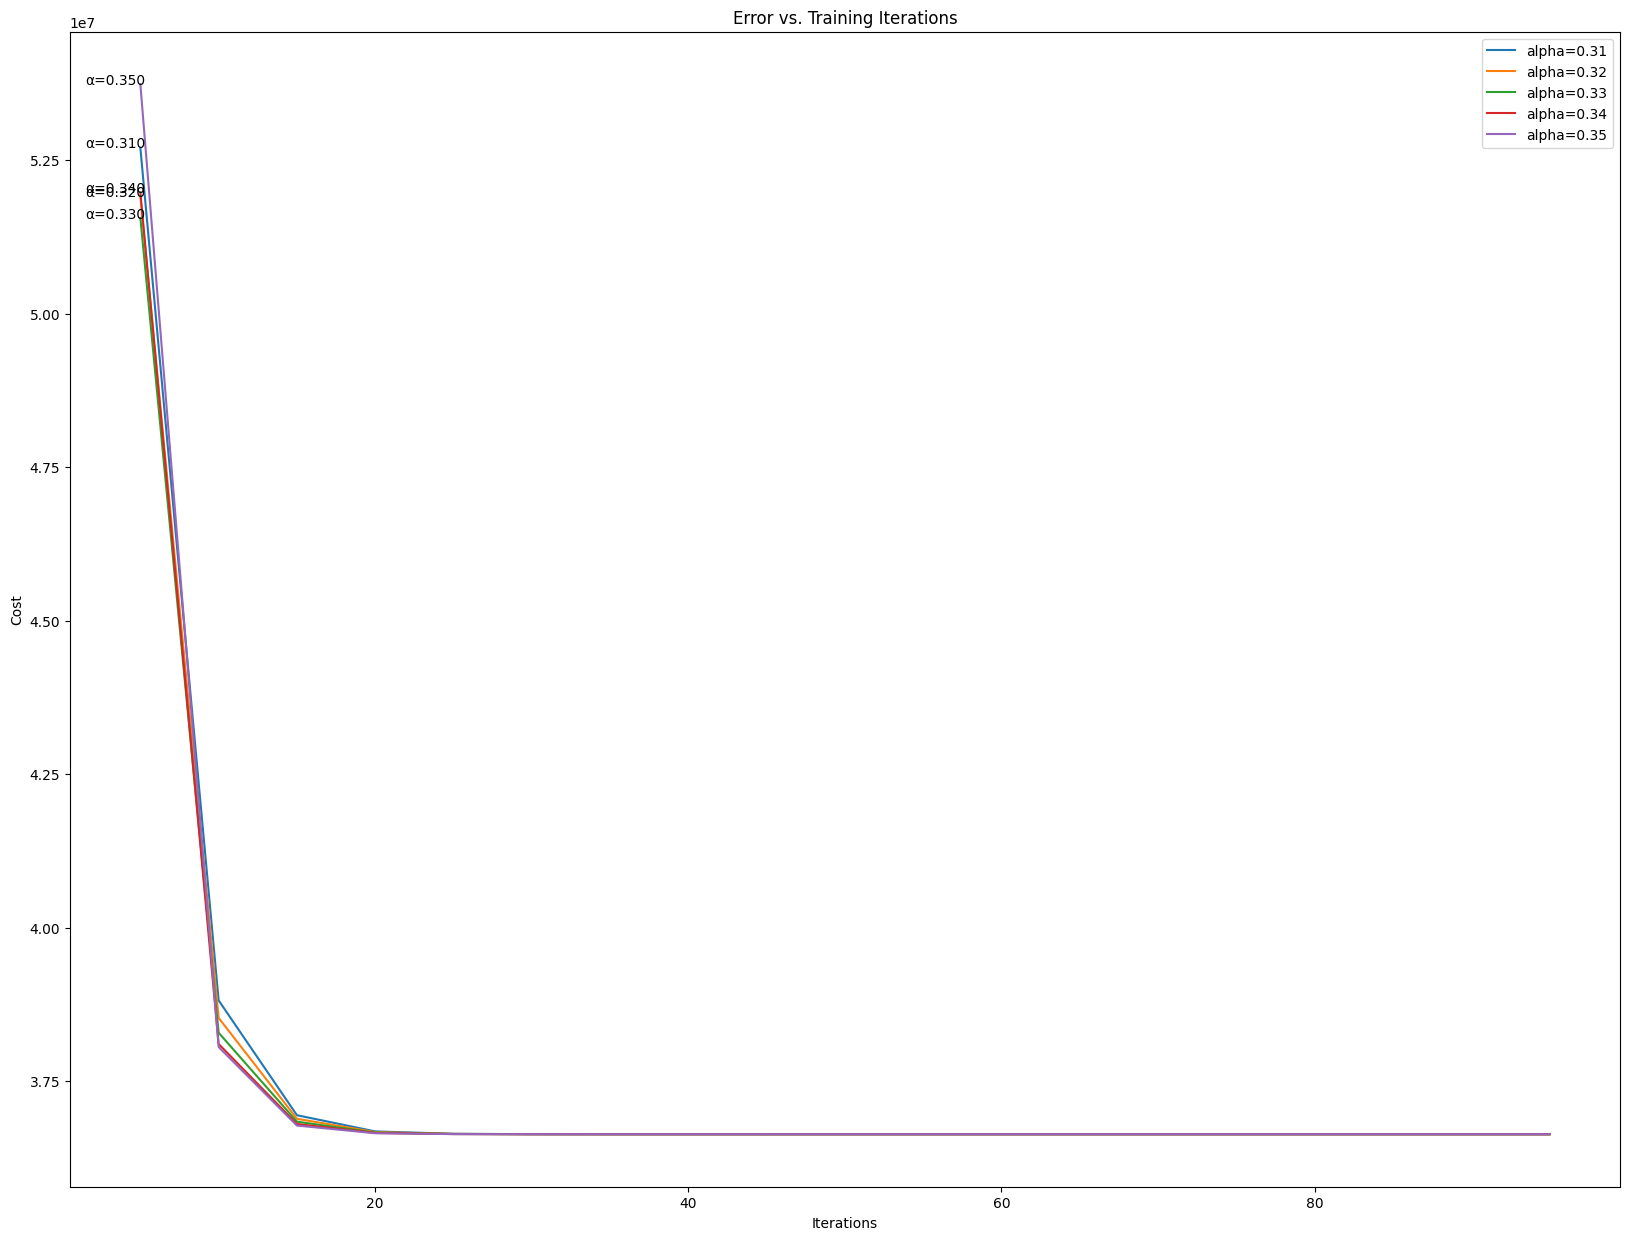

In [162]:
# Focus around 0.33
plotLearningRate(list(range(5,100,5)), [3100,3200,3300,3400,3500], figsize = (20,15))

Thus, we can see from the graphs that 0.33 seems to be the optimal learning rate for the quickest convergence.

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement:

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [163]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

36634753.19889076

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you must use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [164]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train,y_train)
y_predict = mySGDModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print(f"SGD Regressor: {mySGDModel_rmse}")

myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
y_predict = myGradientDescentModel.predict(X_test)
myGD_rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print(f"Custom GD gradient descent: {mySGDModel_rmse}")

myGradientDescentModel.fitUsingNormalEquation(X_train, y_train)
y_predict = myGradientDescentModel.predict(X_test)
mynormal_rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print(f"Custom GD normal equation: {mynormal_rmse}")

SGD Regressor: 6027.63802512675
Custom GD gradient descent: 6027.63802512675
Custom GD normal equation: 6020.272840487451


The built-in Stochastic Regressor model and my own regressor seem to yeild the same result (6027.71), while my normal equation seems to do slightly better at 6020.27. Considering the standard deviation of the charges from the dataset is 12110.011, I would say that the models did pretty well at predicting the values.

- - -
## Task 6. PRESENT YOUR SOLUTION

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following:

* How can you pitch your solution to this project?
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

From the above results, we can see that the RMSE of my model to predict charges is low, significantly less than the standard deviation of the training dataset, which indicates a useful model to predict charges based on my input parameters.

Three potential models were tested and can predict potential medical charges based on certain patient attributes with sufficient accuracy and can be a very useful cost- and time-saving tool. In the end, the model using the normal equation yielded the best results, and has been chosen.

By developing the model, I learned the importance of choosing a balanced learning rate to yeild the most accurate results while maintaining efficiency.

During the data splitting, I used a stratified sampling split based on the feature "smoker", which I observed to be the value that has the most correlation to the final "charges" output. Note that all other values have very low correlation values with the final output, so going forward, it might be better to use another type of non-linear regression.

- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS 4774 Assignment 1:...".

Best of luck and have fun!